# PROJECT 4 - Fatal Accident Data

In [1]:
# Import required libraries
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import findspark
from pyspark import SparkFiles
from pyspark.sql import SparkSession
from mrjob.job import MRJob
import geopandas as gpd
from pprint import pprint
import warnings
import seaborn as sns
import mplcursors
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
warnings.filterwarnings('ignore')

In [3]:
file_path = 'C:/Users/mmack/OneDrive/Desktop/temp_holding_folder/FARS2022NationalCSV/accident.csv'

In [7]:
# Specify the columns to import
use_columns = ['STATENAME', 'ST_CASE', 'PEDS', 'VE_TOTAL', 'COUNTYNAME', 'CITYNAME', 'MONTH', 'DAY', 'YEAR', 'HOUR', 'MINUTE', 'TWAY_ID', 'TWAY_ID2', 
               'RUR_URBNAME', 'LATITUDE', 'LONGITUD', 'HARM_EVNAME', 'WEATHERNAME', 'NOT_HOUR', 'NOT_MIN', 'ARR_HOUR', 'ARR_MIN', 
               'HOSP_HR', 'HOSP_MN', 'FATALS']

# Read the CSV file using Pandas
df = pd.read_csv('C:/Users/mmack/OneDrive/Desktop/temp_holding_folder/FARS2022NationalCSV/accident.csv', encoding='latin1', usecols=use_columns)

# Check unique values in 'STATENAME' column
print(df['STATENAME'].unique())

# Filter for 'STATENAME' as 'CA' and correct the column name
ca_df = df[df['STATENAME'] == 'California']
ca_df.rename(columns={'LONGITUD': 'LONGITUDE'}, inplace=True)
ca_df.head()

['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']


,STATENAME,ST_CASE,PEDS,VE_TOTAL,COUNTYNAME,CITYNAME,MONTH,DAY,YEAR,HOUR,...,LONGITUDE,HARM_EVNAME,WEATHERNAME,NOT_HOUR,NOT_MIN,ARR_HOUR,ARR_MIN,HOSP_HR,HOSP_MN,FATALS
2754,California,60001,0,1,AMADOR (5),NOT APPLICABLE,1,2,2022,22,...,-120.641136,Other Fixed Object,Cloudy,22,45,23,0,99,99,1
2755,California,60002,0,2,SUTTER (101),NOT APPLICABLE,1,15,2022,7,...,-121.828386,Motor Vehicle In-Transport,"Fog, Smog, Smoke",99,99,99,99,88,88,1
2756,California,60003,0,2,RIVERSIDE (65),NOT APPLICABLE,1,4,2022,15,...,-116.315058,Motor Vehicle In-Transport,Clear,99,99,99,99,99,99,1
2757,California,60004,0,1,SAN DIEGO (73),NOT APPLICABLE,1,8,2022,11,...,-117.025567,Embankment,Cloudy,99,99,99,99,99,99,1
2758,California,60005,1,1,SACRAMENTO (67),NOT APPLICABLE,1,13,2022,17,...,-121.408978,Pedestrian,Clear,18,0,18,12,88,88,1


## CLEAN DF & CREATE NEW & CALCULATED COLUMNS FOR ANALYSIS

In [13]:
# Create ACCIDENT_DATE column
ca_df['ACCIDENT_DATE'] = pd.to_datetime(ca_df[['YEAR', 'MONTH', 'DAY']])

# Function to validate time values
def validate_time(hour, minute):
    if 0 <= hour < 24 and 0 <= minute < 60:
        return True
    return False

# Replace any numbers over 60 with '00' in time-related columns
time_columns = ['NOT_HOUR', 'NOT_MIN', 'ARR_HOUR', 'ARR_MIN', 'HOSP_HR', 'HOSP_MN']
for col in time_columns:
    ca_df[col] = ca_df[col].apply(lambda x: 0 if x > 60 else x)

# Merge hour and minute columns into new datetime columns with validation
ca_df['NOT_TIME'] = ca_df.apply(lambda row: pd.to_datetime(f"{row['YEAR']}-{row['MONTH']}-{row['DAY']} {row['NOT_HOUR']}:{row['NOT_MIN']}")
                                           if validate_time(row['NOT_HOUR'], row['NOT_MIN']) else pd.NaT, axis=1)
ca_df['AMBO_ARR_TIME'] = ca_df.apply(lambda row: pd.to_datetime(f"{row['YEAR']}-{row['MONTH']}-{row['DAY']} {row['ARR_HOUR']}:{row['ARR_MIN']}")
                                                if validate_time(row['ARR_HOUR'], row['ARR_MIN']) else pd.NaT, axis=1)
ca_df['HOSP_ARR_TIME'] = ca_df.apply(lambda row: pd.to_datetime(f"{row['YEAR']}-{row['MONTH']}-{row['DAY']} {row['HOSP_HR']}:{row['HOSP_MN']}")
                                                if validate_time(row['HOSP_HR'], row['HOSP_MN']) else pd.NaT, axis=1)

# Replace NaT values with ACCIDENT_DATE and '00:00:00' as the time component
ca_df['NOT_TIME'] = ca_df['NOT_TIME'].fillna(ca_df['ACCIDENT_DATE'].astype(str) + ' 00:00:00')
ca_df['AMBO_ARR_TIME'] = ca_df['AMBO_ARR_TIME'].fillna(ca_df['ACCIDENT_DATE'].astype(str) + ' 00:00:00')
ca_df['HOSP_ARR_TIME'] = ca_df['HOSP_ARR_TIME'].fillna(ca_df['ACCIDENT_DATE'].astype(str) + ' 00:00:00')

# Convert the filled columns back to datetime
ca_df['NOT_TIME'] = pd.to_datetime(ca_df['NOT_TIME'])
ca_df['AMBO_ARR_TIME'] = pd.to_datetime(ca_df['AMBO_ARR_TIME'])
ca_df['HOSP_ARR_TIME'] = pd.to_datetime(ca_df['HOSP_ARR_TIME'])

# Create calculated fields for time differences
ca_df['TIME_TO_AMBO'] = (ca_df['AMBO_ARR_TIME'] - ca_df['NOT_TIME']).dt.total_seconds() / 60  # Time in minutes
ca_df['TIME_TO_HOSP'] = (ca_df['HOSP_ARR_TIME'] - ca_df['AMBO_ARR_TIME']).dt.total_seconds() / 60  # Time in minutes

# Replace negative time differences with 0
ca_df['TIME_TO_AMBO'] = ca_df['TIME_TO_AMBO'].apply(lambda x: 0 if x < 0 else x)
ca_df['TIME_TO_HOSP'] = ca_df['TIME_TO_HOSP'].apply(lambda x: 0 if x < 0 else x)

# display first 5 rows
ca_df.head()

,STATENAME,ST_CASE,PEDS,VE_TOTAL,COUNTYNAME,CITYNAME,MONTH,DAY,YEAR,HOUR,...,ARR_MIN,HOSP_HR,HOSP_MN,FATALS,ACCIDENT_DATE,NOT_TIME,AMBO_ARR_TIME,HOSP_ARR_TIME,TIME_TO_AMBO,TIME_TO_HOSP
2754,California,60001,0,1,AMADOR (5),NOT APPLICABLE,1,2,2022,22,...,0,0,0,1,2022-01-02,2022-01-02 22:45:00,2022-01-02 23:00:00,2022-01-02,15.0,0.0
2755,California,60002,0,2,SUTTER (101),NOT APPLICABLE,1,15,2022,7,...,0,0,0,1,2022-01-15,2022-01-15 00:00:00,2022-01-15 00:00:00,2022-01-15,0.0,0.0
2756,California,60003,0,2,RIVERSIDE (65),NOT APPLICABLE,1,4,2022,15,...,0,0,0,1,2022-01-04,2022-01-04 00:00:00,2022-01-04 00:00:00,2022-01-04,0.0,0.0
2757,California,60004,0,1,SAN DIEGO (73),NOT APPLICABLE,1,8,2022,11,...,0,0,0,1,2022-01-08,2022-01-08 00:00:00,2022-01-08 00:00:00,2022-01-08,0.0,0.0
2758,California,60005,1,1,SACRAMENTO (67),NOT APPLICABLE,1,13,2022,17,...,12,0,0,1,2022-01-13,2022-01-13 18:00:00,2022-01-13 18:12:00,2022-01-13,12.0,0.0


In [15]:
ca_df


,STATENAME,ST_CASE,PEDS,VE_TOTAL,COUNTYNAME,CITYNAME,MONTH,DAY,YEAR,HOUR,...,ARR_MIN,HOSP_HR,HOSP_MN,FATALS,ACCIDENT_DATE,NOT_TIME,AMBO_ARR_TIME,HOSP_ARR_TIME,TIME_TO_AMBO,TIME_TO_HOSP
2754,California,60001,0,1,AMADOR (5),NOT APPLICABLE,1,2,2022,22,...,0,0,0,1,2022-01-02,2022-01-02 22:45:00,2022-01-02 23:00:00,2022-01-02,15.0,0.0
2755,California,60002,0,2,SUTTER (101),NOT APPLICABLE,1,15,2022,7,...,0,0,0,1,2022-01-15,2022-01-15 00:00:00,2022-01-15 00:00:00,2022-01-15,0.0,0.0
2756,California,60003,0,2,RIVERSIDE (65),NOT APPLICABLE,1,4,2022,15,...,0,0,0,1,2022-01-04,2022-01-04 00:00:00,2022-01-04 00:00:00,2022-01-04,0.0,0.0
2757,California,60004,0,1,SAN DIEGO (73),NOT APPLICABLE,1,8,2022,11,...,0,0,0,1,2022-01-08,2022-01-08 00:00:00,2022-01-08 00:00:00,2022-01-08,0.0,0.0
2758,California,60005,1,1,SACRAMENTO (67),NOT APPLICABLE,1,13,2022,17,...,12,0,0,1,2022-01-13,2022-01-13 18:00:00,2022-01-13 18:12:00,2022-01-13,12.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6858,California,64157,1,1,SANTA CLARA (85),SAN JOSE,2,10,2022,20,...,0,0,0,1,2022-02-10,2022-02-10 00:00:00,2022-02-10 00:00:00,2022-02-10,0.0,0.0
6859,California,64158,0,2,ORANGE (59),MISSION VIEJO,11,5,2022,3,...,0,0,0,2,2022-11-05,2022-11-05 03:49:00,2022-11-05 00:00:00,2022-11-05,0.0,0.0
6860,California,64159,0,2,LOS ANGELES (37),NOT APPLICABLE,12,3,2022,22,...,0,0,0,1,2022-12-03,2022-12-03 00:00:00,2022-12-03 00:00:00,2022-12-03,0.0,0.0
6861,California,64160,0,3,RIVERSIDE (65),PALM DESERT,6,1,2022,20,...,0,0,0,2,2022-06-01,2022-06-01 00:00:00,2022-06-01 00:00:00,2022-06-01,0.0,0.0


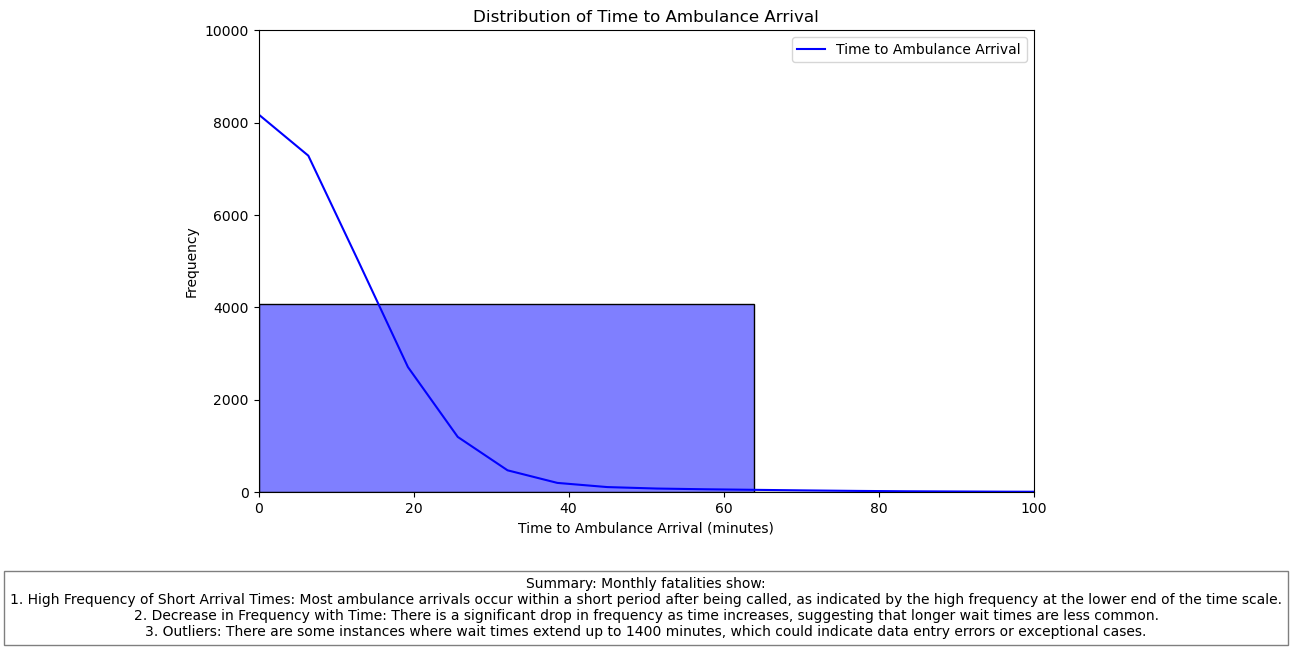

In [19]:
# Cap the frequency values at 100
max_frequency = 100000

# Response Time to Ambulance Arrival:
plt.figure(figsize=(10, 6))
sns.histplot(ca_df['TIME_TO_AMBO'], bins=20, kde=True, color='blue')
plt.title('Distribution of Time to Ambulance Arrival')
plt.xlabel('Time to Ambulance Arrival (minutes)')
plt.ylabel('Frequency')
plt.legend(['Time to Ambulance Arrival'])
plt.xlim(0, 100)  # Set x-axis range to 200
plt.ylim(0, 10000)  # Limit the frequency value to 100

# Add summary text box
summary_text = (
    "Summary: Monthly fatalities show:\n"
    "1. High Frequency of Short Arrival Times: Most ambulance arrivals occur within a short period after being called, "
    "as indicated by the high frequency at the lower end of the time scale.\n"
    "2. Decrease in Frequency with Time: There is a significant drop in frequency as time increases, suggesting that longer wait times are less common.\n"
    "3. Outliers: There are some instances where wait times extend up to 1400 minutes, which could indicate data entry errors or exceptional cases."
)
plt.text(0.5, -0.25, summary_text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
plt.savefig('time_to_ambo_arr.png')
plt.show()

In [20]:
ca_df.to_csv('c:/users/mmack/onedrive/desktop/fatal_accident_df.csv', index=False)

## CREATE CA ONLY VISUALIZATION

In [23]:
# Create a new dataframe with only the required columns and filter for California
accident_geo_ca_df = ca_df[['STATENAME', 'ST_CASE', 'FATALS', 'LATITUDE', 'LONGITUDE']]
accident_geo_ca_df = accident_geo_ca_df[ca_df['STATENAME'] == 'California']

# Display the first 5 rows of the DataFrame
accident_geo_ca_df

,STATENAME,ST_CASE,FATALS,LATITUDE,LONGITUDE
2754,California,60001,1,38.403658,-120.641136
2755,California,60002,1,39.147700,-121.828386
2756,California,60003,1,33.816272,-116.315058
2757,California,60004,1,33.086403,-117.025567
2758,California,60005,1,38.481636,-121.408978
...,...,...,...,...,...
6858,California,64157,1,37.277867,-121.880136
6859,California,64158,2,33.555514,-117.673081
6860,California,64159,1,33.930994,-118.317778
6861,California,64160,2,33.801675,-116.410139


In [24]:
display(ca_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4109 entries, 2754 to 6862
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   STATENAME      4109 non-null   object        
 1   ST_CASE        4109 non-null   int64         
 2   PEDS           4109 non-null   int64         
 3   VE_TOTAL       4109 non-null   int64         
 4   COUNTYNAME     4109 non-null   object        
 5   CITYNAME       4109 non-null   object        
 6   MONTH          4109 non-null   int64         
 7   DAY            4109 non-null   int64         
 8   YEAR           4109 non-null   int64         
 9   HOUR           4109 non-null   int64         
 10  MINUTE         4109 non-null   int64         
 11  TWAY_ID        4109 non-null   object        
 12  TWAY_ID2       1081 non-null   object        
 13  RUR_URBNAME    4109 non-null   object        
 14  LATITUDE       4109 non-null   float64       
 15  LONGITUDE      4109 non

None